In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.model_selection import train_test_split

# Create dataframe

In [8]:
ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/UShape"
no_ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/NoUshape"

In [9]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.path)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)

print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3822


In [10]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_total = fill_df_with_label(ushapes_spectrograms, "ushape").append(fill_df_with_label(no_ushape_spectrograms, "noshape"))


df_train, df_rest = train_test_split(dataframe_total, random_state = 101, test_size=0.25)
df_val, df_eval = train_test_split(df_rest, random_state = 101, test_size=0.50)


In [5]:
print(df_val)

                                               filename    label
2292  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
2164  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1575  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1342  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1749  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
...                                                 ...      ...
605   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
50    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
646   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
35    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1869  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape

[499 rows x 2 columns]


In [11]:
# Initialize the Pretrained Model
feature_extractor = VGG16(include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
print(df_val)

                                               filename    label
2292  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
2164  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1575  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1342  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1749  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
...                                                 ...      ...
605   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
50    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
646   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
35    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1869  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape

[499 rows x 2 columns]


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 2992 validated image filenames belonging to 2 classes.
Found 499 validated image filenames belonging to 2 classes.


In [13]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/50
94/94 [==============================] - 571s 6s/step - loss: 0.2815 - accuracy: 0.9392 - val_loss: 0.2529 - val_accuracy: 0.9339
Epoch 2/50
94/94 [==============================] - 534s 6s/step - loss: 0.1809 - accuracy: 0.9485 - val_loss: 0.1935 - val_accuracy: 0.9399
Epoch 3/50
94/94 [==============================] - 546s 6s/step - loss: 0.1503 - accuracy: 0.9532 - val_loss: 0.1866 - val_accuracy: 0.9279
Epoch 4/50
94/94 [==============================] - 513s 5s/step - loss: 0.1387 - accuracy: 0.9555 - val_loss: 0.1968 - val_accuracy: 0.9499
Epoch 5/50
94/94 [==============================] - 519s 6s/step - loss: 0.1370 - accuracy: 0.9545 - val_loss: 0.1507 - val_accuracy: 0.9459
Epoch 6/50
94/94 [==============================] - 517s 6s/step - loss: 0.1384 - accuracy: 0.9542 - val_loss: 0.1291 - val_accuracy: 0.9539
Epoch 7/50
94/94 [==============================] - 522s 6s/step - loss: 0.1312 - accuracy: 0.9569 - val_loss: 0.1728 - val_accuracy: 0.9499
Epoch 8/50
94

In [14]:
model.save('./harp_transfer_vgg16_more_50epochs')

INFO:tensorflow:Assets written to: ./harp_transfer_vgg16_more_50epochs\assets


INFO:tensorflow:Assets written to: ./harp_transfer_vgg16_more_50epochs\assets


In [18]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: 

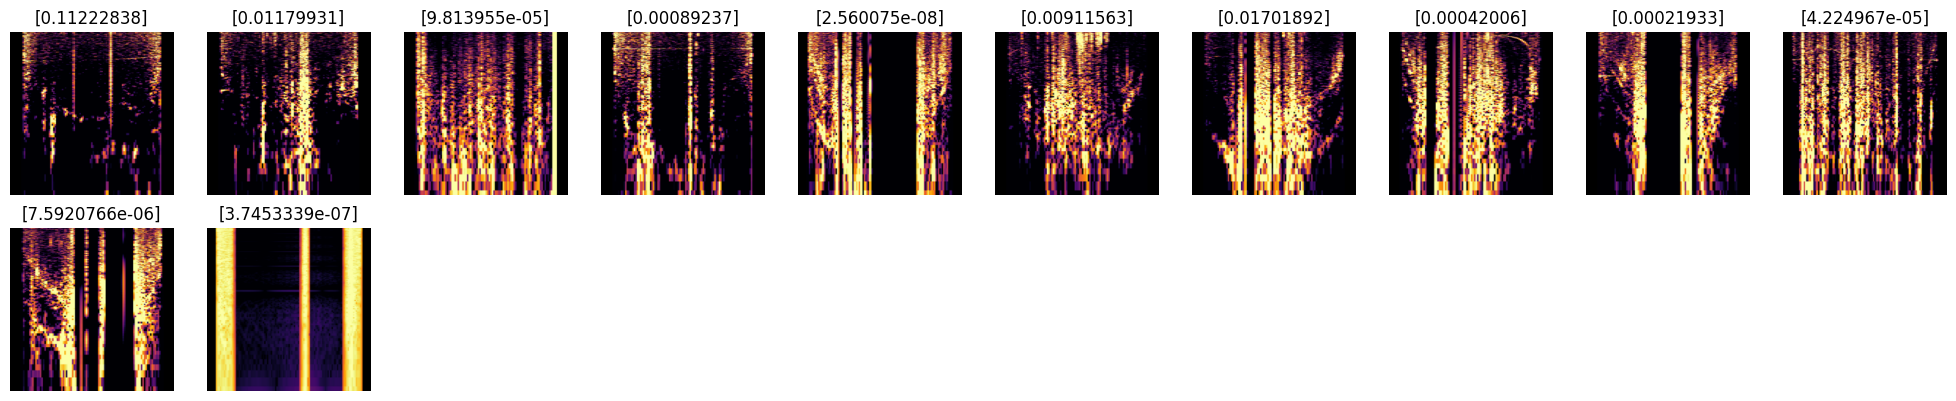

In [36]:
y_true = df_eval.loc[df_eval['label'] == 'noshape'] 
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in y_true['filename']:
    img = tf.keras.utils.load_img(
        image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')

    if predictions > 0.5:
        y_pred.append(image_to_predict)

        plt.imshow(img_array[0].numpy().astype("uint8"))
        index += 1


1/1 [==============================] - 0s 27ms/step


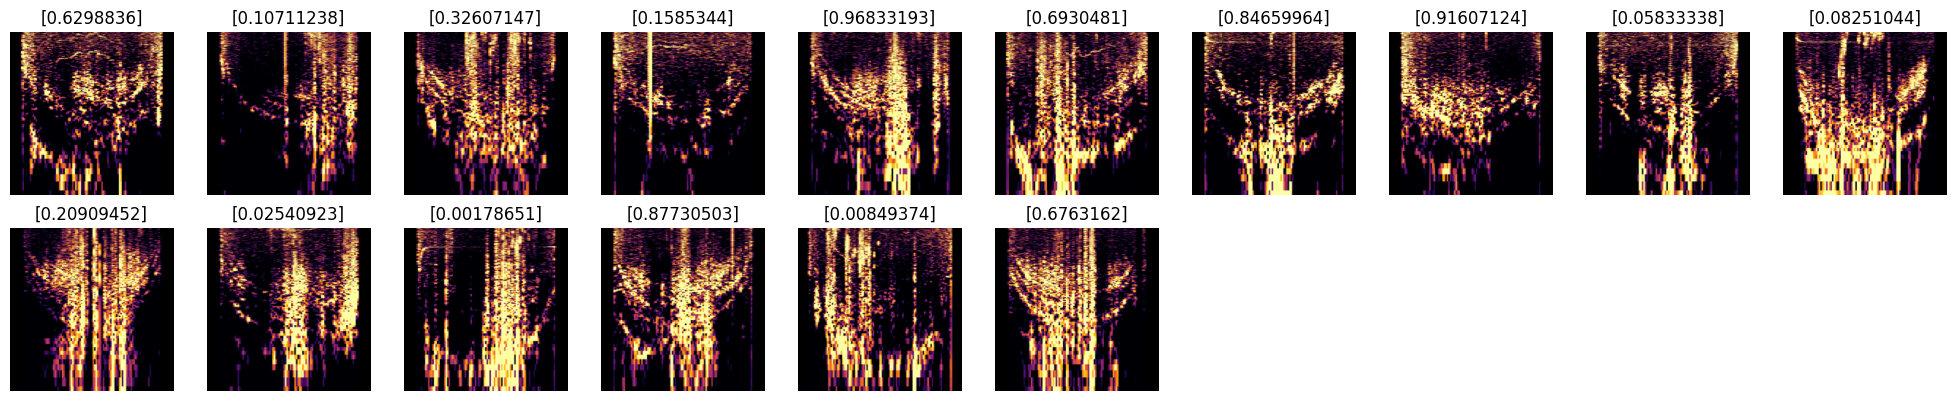

In [34]:
y_true = df_eval.loc[df_eval['label'] == 'ushape'] 
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in y_true['filename']:
    img = tf.keras.utils.load_img(
        image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')


    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1


In [21]:
def predcit_image(file_to_test):
  img = tf.keras.utils.load_img(
          file_to_test, target_size=(224, 224)
      )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)


  plt.axis('off')

  plt.imshow(img_array[0].numpy().astype("uint8"))

  print(predictions[0])



1/1 [==============================] - 3s 3s/step
[0.0019354]


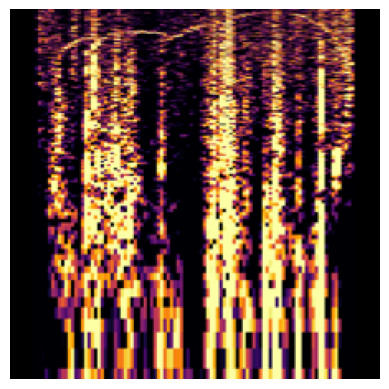

In [22]:
file_to_test = no_ushapes + "/THE_stft_20170206_20170207_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 32ms/step
[0.12264749]


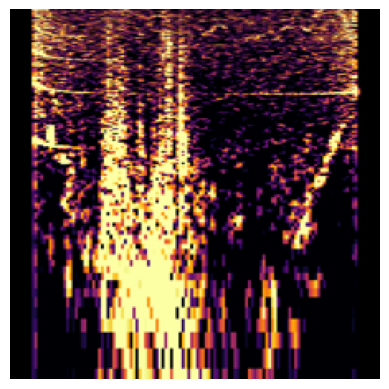

In [23]:
file_to_test = no_ushapes + "/THE_stft_20170524_20170525_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 25ms/step
[1.4877518e-08]


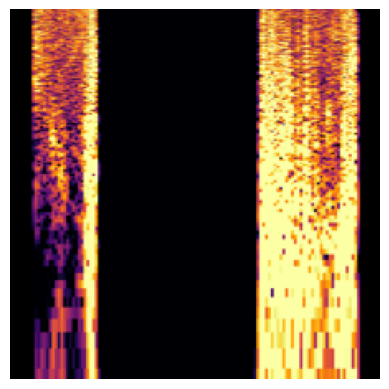

In [24]:
file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 25ms/step
[1.4877518e-08]


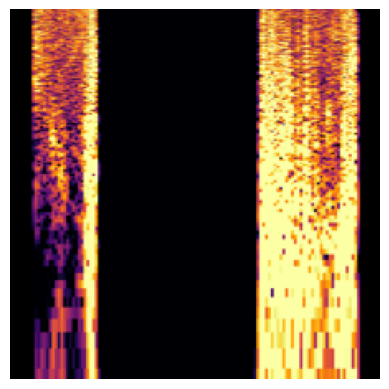

In [25]:

file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 24ms/step
[0.00026231]


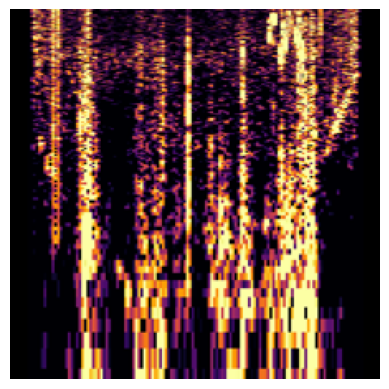

In [26]:
file_to_test = no_ushapes + "/THE_stft_20190203_20190204_dynamic.png"
predcit_image(file_to_test)

In [ ]:
print(model.history.history)

{}


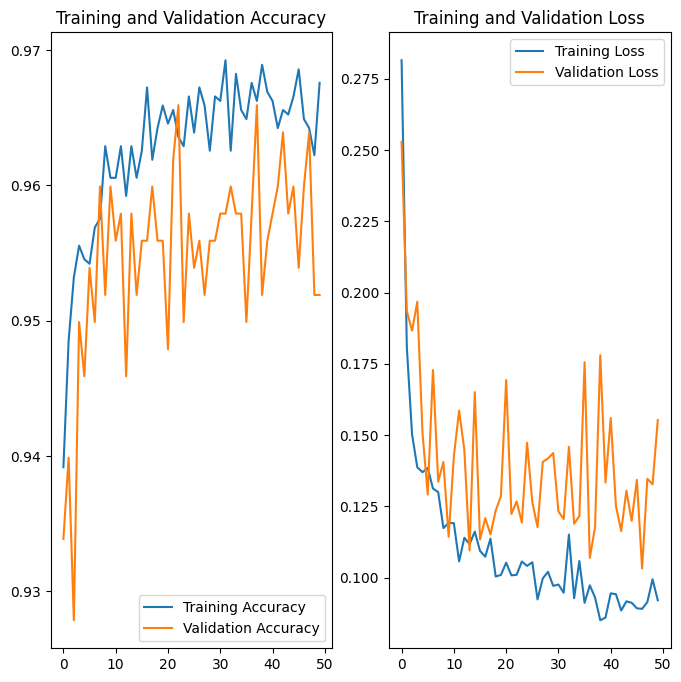

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()